# 기상 상황에 따른 서울시 공공자전거 이용건수 예측 및 정책 제안

2023.11.26 ~ 2023.12.10

---

## 1. 프로젝트 개요

### 1-1. 요약
- 제목: 기상 상황에 따른 서울시 공공자전거 이용건수 예측 및 정책 제안
- 설명: 서울시 공공자전거 데이터와 날씨 데이터를 분석하여, 날씨에 따른 공공자전거 이용건수를 예측
- 사용한 데이터셋
    - [서울시 공공자전거 이용현황](https://data.seoul.go.kr/dataList/OA-14994/F/1/datasetView.do): 서울시에서 운영하는 공공자전거(따릉이)에 대한 기간별, 대여소별 이용(대여, 반납)현황 데이터
    - [기상청_지상(종관, ASOS) 일자료 조회서비스](https://data.seoul.go.kr/dataList/OA-14994/F/1/datasetView.do): 종관기상관측 장비로 관측한 일 기상자료
- 진행 절차 및 내용
    - **API 데이터 로딩**하여 각 컬럼들의 분포 확인 및 시각화, 필요한 파생 컬럼 생성
    - 서울시 입장의 가상 시나리오 하 공공자전거 이용건수 예측 **ML 모델 생성** 및 튜닝
    - 예측 이용자 수가 낮은 날과 높은 날의 기준 설정하여 **정책 제안**
- 사용한 스킬셋
    - pandas, numpy
    - matplotlib, seaborn
    - requests, json
    - scikit-learn

### 1-2. 프로젝트 진행 배경

따릉이는 서울특별시에서 운영하는 무인 공공자전거 시스템이다. 현재 서울시 전역의 약 2,700개의 대여소에서 약 43,500대의 자전거가 운영되고 있다.

공공자전거의 도입에는 여러 장점이 있다. 지근거리 이동에 자동차의 대용으로 활용할 수 있기 때문에 화석연료 사용을 줄이고 대기오염을 예방할 수 있다. 또한 차량 운전 대신 공공자전거 이용을 유도하여 교통량 분산 및 교통체증 해소를 도모할 수 있다. 시민들의 건강 증진에 큰 도움을 주기도 한다. 이렇듯 서울시 공공자전거 정책은 여러 긍정적인 효과를 유발한다.

하지만 공공자전거의 이용은 **날씨의 영향**을 크게 받는다는 치명적인 맹점이 있다. 악천후, 혹한, 기상 재해 등의 상황에서 자전거 이용량이 큰 폭으로 감소하는 문제가 있다. 이는 앞서 나열한 공공자전거 정책의 목표 달성에 다소 위협이 되는 요인이다.

본 프로젝트에서는 2022년 11월부터 2023년 10월까지의 서울시 공공자전거 이용건수 데이터와 기상청 날씨 데이터를 연계하여 분석한다. 이를 통해 날씨에 따른 공공자전거 이용건수를 예측해보고, 이 예측치를 실제 정책에 활용할 수 있는 방안을 살펴본다.

---

## 2. 데이터 로딩 및 EDA

### 2-1. 서울시 공공자전거 이용현황

#### 2-1-1. 데이터 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import pickle
import requests
import json
import math
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [6]:
# 2022년 11월부터 2023년 10월까지의 날짜 생성
months = {
    '2022-11': 30, '2022-12': 31, '2023-01': 31, '2023-02': 28, '2023-03': 31, '2023-04': 30,
    '2023-05': 31, '2023-06': 30, '2023-07': 31, '2023-08': 31, '2023-09': 30, '2023-10': 31
}
dates = []

for month, days in months.items():
    for day in range(1, days + 1):
        dates.append(f'{month}-0{str(day)}' if day < 10 else f'{month}-{str(day)}')
        
print(len(dates))

365


In [7]:
results = []

# 365일 전체에 대한 데이터 불러오기
for date in dates:
    n = 0 #한 번에 최대 1000개씩 불러올 수 있어서, 여러 번에 나눠서 불러오기 위한 변수
    while True:
        # URL 구성
        url = f'http://openapi.seoul.go.kr:8088'
        params = {
            'key': '73495157686c6f7537384768786b71',
            'type': 'json',
            'service': 'tbCycleUseStatus',
            'start_index': str(n * 1000 + 1),
            'end_index': str((n + 1) * 1000),
            'start_data': date
        }
        for param in params.values():
            url += '/' + param

        # 완성된 URL로부터 데이터 수신
        response = requests.get(url)

        # 받아온 결과를 utf-8 디코딩
        response_data = response.content.decode('utf-8')

        # JSON 문자열을 딕셔너리로 파싱
        response_dict = json.loads(response_data)

        # 결과를 리스트에 저장하고 다음 페이지로 이동
        # 단, 결과가 없는 경우 해당 날짜를 종료
        try:
            results += response_dict['useStatus']['row']
            n += 1
        except:
            break
    
    print(f'{date} 데이터 수신 완료! 현재 데이터 개수 {len(results)}개')

2022-11-01 데이터 수신 완료! 현재 데이터 개수 2658개
2022-11-02 데이터 수신 완료! 현재 데이터 개수 5322개
2022-11-03 데이터 수신 완료! 현재 데이터 개수 7983개
2022-11-04 데이터 수신 완료! 현재 데이터 개수 10639개
2022-11-05 데이터 수신 완료! 현재 데이터 개수 13292개
2022-11-06 데이터 수신 완료! 현재 데이터 개수 15943개
2022-11-07 데이터 수신 완료! 현재 데이터 개수 18603개
2022-11-08 데이터 수신 완료! 현재 데이터 개수 21267개
2022-11-09 데이터 수신 완료! 현재 데이터 개수 23930개
2022-11-10 데이터 수신 완료! 현재 데이터 개수 26594개
2022-11-11 데이터 수신 완료! 현재 데이터 개수 29261개
2022-11-12 데이터 수신 완료! 현재 데이터 개수 31906개
2022-11-13 데이터 수신 완료! 현재 데이터 개수 34564개
2022-11-14 데이터 수신 완료! 현재 데이터 개수 37223개
2022-11-15 데이터 수신 완료! 현재 데이터 개수 39886개
2022-11-16 데이터 수신 완료! 현재 데이터 개수 42544개
2022-11-17 데이터 수신 완료! 현재 데이터 개수 45205개
2022-11-18 데이터 수신 완료! 현재 데이터 개수 47864개
2022-11-19 데이터 수신 완료! 현재 데이터 개수 50523개
2022-11-20 데이터 수신 완료! 현재 데이터 개수 53175개
2022-11-21 데이터 수신 완료! 현재 데이터 개수 55836개
2022-11-22 데이터 수신 완료! 현재 데이터 개수 58494개
2022-11-23 데이터 수신 완료! 현재 데이터 개수 61153개
2022-11-24 데이터 수신 완료! 현재 데이터 개수 63815개
2022-11-25 데이터 수신 완료! 현재 데이터 개수 66474개
2022-11-26 데이터 수신 완료! 현재 데이터

2023-05-26 데이터 수신 완료! 현재 데이터 개수 553640개
2023-05-27 데이터 수신 완료! 현재 데이터 개수 556305개
2023-05-28 데이터 수신 완료! 현재 데이터 개수 558428개
2023-05-29 데이터 수신 완료! 현재 데이터 개수 561131개
2023-05-30 데이터 수신 완료! 현재 데이터 개수 563838개
2023-05-31 데이터 수신 완료! 현재 데이터 개수 566541개
2023-06-01 데이터 수신 완료! 현재 데이터 개수 569246개
2023-06-02 데이터 수신 완료! 현재 데이터 개수 571949개
2023-06-03 데이터 수신 완료! 현재 데이터 개수 574649개
2023-06-04 데이터 수신 완료! 현재 데이터 개수 577348개
2023-06-05 데이터 수신 완료! 현재 데이터 개수 580051개
2023-06-06 데이터 수신 완료! 현재 데이터 개수 582748개
2023-06-07 데이터 수신 완료! 현재 데이터 개수 585452개
2023-06-08 데이터 수신 완료! 현재 데이터 개수 588150개
2023-06-09 데이터 수신 완료! 현재 데이터 개수 590849개
2023-06-10 데이터 수신 완료! 현재 데이터 개수 593546개
2023-06-11 데이터 수신 완료! 현재 데이터 개수 596240개
2023-06-12 데이터 수신 완료! 현재 데이터 개수 598943개
2023-06-13 데이터 수신 완료! 현재 데이터 개수 601643개
2023-06-14 데이터 수신 완료! 현재 데이터 개수 604344개
2023-06-15 데이터 수신 완료! 현재 데이터 개수 607037개
2023-06-16 데이터 수신 완료! 현재 데이터 개수 609737개
2023-06-17 데이터 수신 완료! 현재 데이터 개수 612434개
2023-06-18 데이터 수신 완료! 현재 데이터 개수 615128개
2023-06-19 데이터 수신 완료! 현재 데이터 개수 617826개


In [8]:
# 데이터프레임 생성
cycle_use_df = pd.DataFrame(results)
cycle_use_df

,STA_LOC,RENT_NM,STAT_DATA,RENT_CNT,RTN_CNT,START_INDEX,END_INDEX
0,양천구,729. 서부식자재마트 건너편,2022-11-01,67,75,0,0
1,양천구,731. 서울시 도로환경관리센터,2022-11-01,76,85,0,0
2,양천구,732. 신월중학교,2022-11-01,53,56,0,0
3,양천구,733. 신정이펜하우스314동,2022-11-01,35,14,0,0
4,양천구,734. 신트리공원 입구,2022-11-01,149,153,0,0
...,...,...,...,...,...,...,...
977036,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-10-31,65,72,0,0
977037,양천구,723. SBS방송국,2023-10-31,130,133,0,0
977038,양천구,724. 계남공원 입구 주출입구 좌측,2023-10-31,11,6,0,0
977039,양천구,725. 양강중학교앞 교차로,2023-10-31,16,15,0,0


In [9]:
cycle_use_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977041 entries, 0 to 977040
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   STA_LOC      977041 non-null  object
 1   RENT_NM      977041 non-null  object
 2   STAT_DATA    977041 non-null  object
 3   RENT_CNT     977041 non-null  object
 4   RTN_CNT      977041 non-null  object
 5   START_INDEX  977041 non-null  int64 
 6   END_INDEX    977041 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 52.2+ MB


In [10]:
cycle_use_df.isna().sum()

STA_LOC        0
RENT_NM        0
STAT_DATA      0
RENT_CNT       0
RTN_CNT        0
START_INDEX    0
END_INDEX      0
dtype: int64

데이터를 간략하게 확인해 본 결과
- 각 컬럼의 이름을 **한글로 변경**해야 할 필요성 느낌
- ```START_INDEX```와 ```END_INDEX```는 뭔지 모르겠으니 삭제
- ```RENT_CNT```와 ```RTN_CNT```는 str로 들어가 있으니 **int로 변경**해야 함

#### 2-1-2. 데이터 확인 및 전처리 (전체)

In [11]:
# 쓸데없는 컬럼 삭제 및 컬럼 이름 한글화
new_cycle_use_df = cycle_use_df.rename(columns={
    'STA_LOC': '그룹명',
    'RENT_NM': '대여소명',
    'STAT_DATA': '대여년월',
    'RENT_CNT': '대여건수',
    'RTN_CNT': '반납건수'
}).drop(['START_INDEX', 'END_INDEX'], axis=1)

new_cycle_use_df

,그룹명,대여소명,대여년월,대여건수,반납건수
0,양천구,729. 서부식자재마트 건너편,2022-11-01,67,75
1,양천구,731. 서울시 도로환경관리센터,2022-11-01,76,85
2,양천구,732. 신월중학교,2022-11-01,53,56
3,양천구,733. 신정이펜하우스314동,2022-11-01,35,14
4,양천구,734. 신트리공원 입구,2022-11-01,149,153
...,...,...,...,...,...
977036,양천구,722. 경서농협 버스정류장(우리은행신정동지점방향),2023-10-31,65,72
977037,양천구,723. SBS방송국,2023-10-31,130,133
977038,양천구,724. 계남공원 입구 주출입구 좌측,2023-10-31,11,6
977039,양천구,725. 양강중학교앞 교차로,2023-10-31,16,15


In [12]:
# 대여건수와 반납건수 컬럼을 int로 변경
new_cycle_use_df['대여건수'] = new_cycle_use_df['대여건수'].astype(int)
new_cycle_use_df['반납건수'] = new_cycle_use_df['반납건수'].astype(int)

new_cycle_use_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977041 entries, 0 to 977040
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   그룹명     977041 non-null  object
 1   대여소명    977041 non-null  object
 2   대여년월    977041 non-null  object
 3   대여건수    977041 non-null  int32 
 4   반납건수    977041 non-null  int32 
dtypes: int32(2), object(3)
memory usage: 29.8+ MB


#### 2-1-3. 데이터 확인 및 전처리 (그룹명)

In [13]:
new_cycle_use_df['그룹명'].nunique()

25

In [14]:
new_cycle_use_df['그룹명'].unique()

array(['양천구', '광진구', '은평구', '성동구', '강동구', '강서구', '송파구', '중랑구', '마포구',
       '강북구', '노원구', '도봉구', '금천구', '동작구', '관악구', '서초구', '중구', '종로구',
       '강남구', '서대문구', '성북구', '구로구', '동대문구', '영등포구', '용산구'], dtype=object)

25개 행정구에 대한 데이터임을 확인

In [15]:
# 그룹별 이용건수
cycle_by_group = new_cycle_use_df.groupby('그룹명').agg({'대여건수': 'sum', '반납건수': 'sum'})
cycle_by_group['이용건수'] = cycle_by_group['대여건수'] + cycle_by_group['반납건수']
cycle_by_group

,대여건수,반납건수,이용건수
그룹명,,,
강남구,1394618,1318609,2713227
강동구,1948972,1961871,3910843
강북구,648956,640911,1289867
강서구,5212259,5191893,10404152
관악구,1124019,1105601,2229620
광진구,2172831,2138187,4311018
구로구,1808042,1799019,3607061
금천구,794126,787533,1581659
노원구,2669572,2657136,5326708


C:\Users\louis\AppData\Local\Temp\ipykernel_14596\2704118023.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


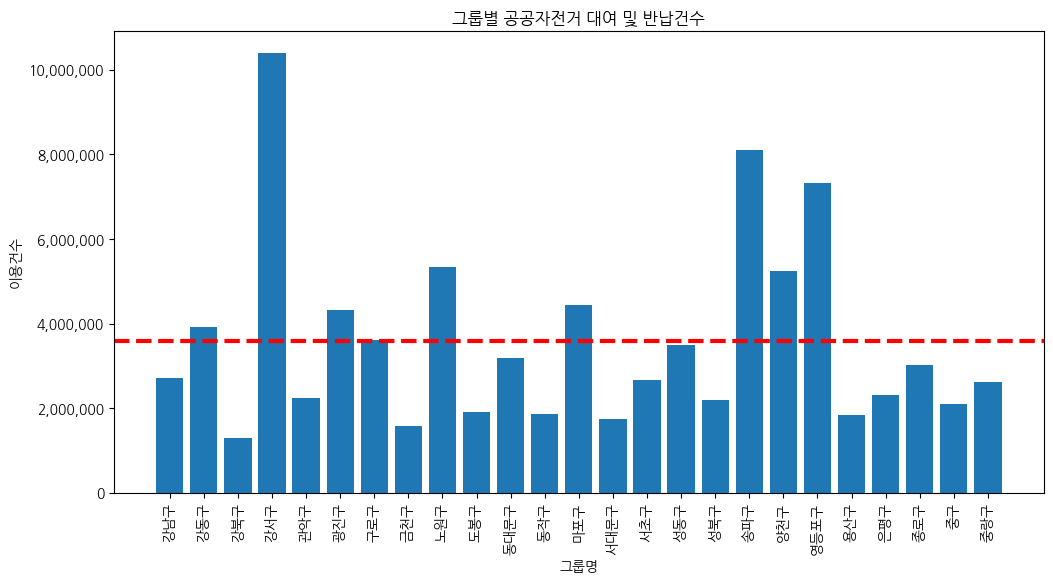

In [39]:
plt.figure(figsize=(12, 6))
plt.bar(cycle_by_group.index, cycle_by_group['이용건수'])
plt.title('그룹별 공공자전거 대여 및 반납건수')
plt.xticks(rotation=90)
plt.xlabel('그룹명')
plt.ylabel('이용건수')
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
plt.axhline(cycle_by_group['이용건수'].mean(), color='red', linestyle='--', linewidth='3')
plt.show()

강서구, 노원구, 마포구, 송파구, 양천구, 영등포구 등의 공공자전거 이용 건수가 많다.

#### 2-1-4. 데이터 확인 및 전처리 (대여소명)

In [38]:
# 대여소 개수
new_cycle_use_df['대여소명'].nunique()

2786

In [45]:
# 그룹별 대여소 개수 
station_in_group = new_cycle_use_df.groupby('그룹명').agg({'대여소명': 'nunique'}).sort_values(
    '대여소명', ascending=False
).rename(columns={'대여소명': '대여소 개수'})
station_in_group

,대여소 개수
그룹명,
송파구,223
강서구,192
강남구,171
영등포구,155
서초구,150
노원구,141
마포구,126
강동구,124
구로구,115


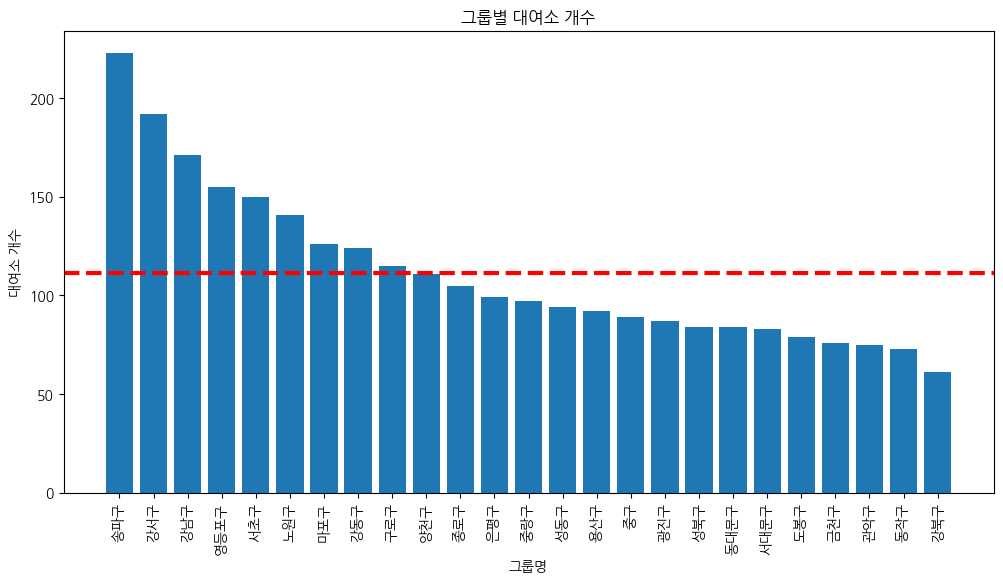

In [47]:
# 시각화
plt.figure(figsize=(12, 6))
plt.bar(station_in_group.index, station_in_group['대여소 개수'])
# station_in_group.plot(kind='bar', figsize=(10, 5))
plt.title('그룹별 대여소 개수')
plt.xlabel('그룹명')
plt.xticks(rotation=90)
plt.ylabel('대여소 개수')
plt.axhline(station_in_group['대여소 개수'].mean(), color='red', linestyle='--', linewidth='3')
plt.show()

송파구, 강서구, 강남구, 영등포구, 서초구, 마포구, 강동구, 구로구 등에 대여소가 많이 분포되어 있다.

#### 2-1-5. 데이터 확인 및 전처리 (대여년월)

In [48]:
new_cycle_use_df['대여년월'].nunique()

364

날짜가 하루 누락되어 있다.

In [49]:
unique_dates = list(new_cycle_use_df['대여년월'].unique())

for date in dates:
    if date not in unique_dates:
        print(date)

2023-06-26


6월 26일은 누락된 상태이지만 일단 그냥 진행한다.

#### 2-1-6. 데이터 확인 및 전처리 (대여건수, 반납건수)

In [50]:
new_cycle_use_df[['대여건수', '반납건수']].describe()

,대여건수,반납건수
count,977041.000000,977041.000000
mean,45.933848,45.568671
std,50.419683,52.197595
min,0.000000,0.000000
25%,14.000000,12.000000
50%,31.000000,30.000000
75%,61.000000,61.000000
max,1384.000000,1573.000000


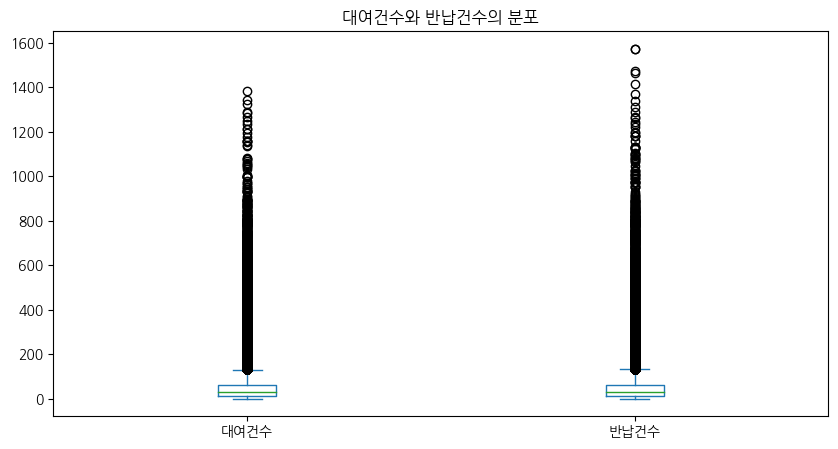

In [51]:
new_cycle_use_df[['대여건수', '반납건수']].plot(kind='box', figsize=(10, 5))
plt.title('대여건수와 반납건수의 분포')
plt.show()

하루에 대여소 한 곳에서 발생되는 이용건수(=대여건수 + 반납건수)는 대략 30건 ~ 120건 내외가 일반적인 모양이다. 다만 이상치가 굉장히 많은데, 대여소별로 편차가 꽤 크지 않을까 예상해본다.

In [54]:
new_cycle_use_df[
    (new_cycle_use_df['대여건수'] == new_cycle_use_df['대여건수'].max()) |
    (new_cycle_use_df['반납건수'] == new_cycle_use_df['반납건수'].max())
]

,그룹명,대여소명,대여년월,대여건수,반납건수
407071,마포구,4217. 한강공원 망원나들목,2023-04-02,1384,1573


최대값은 벚꽃 시즌 한강공원

In [55]:
new_cycle_use_df[
    (new_cycle_use_df['대여건수'] == new_cycle_use_df['대여건수'].min()) |
    (new_cycle_use_df['반납건수'] == new_cycle_use_df['반납건수'].min())
]

,그룹명,대여소명,대여년월,대여건수,반납건수
276,서초구,2286. 탑성마을입구,2022-11-01,1,0
587,성동구,3538. 서울숲 IT캐슬,2022-11-01,0,1
1067,용산구,865.하얏트호텔 앞,2022-11-01,10,0
1097,성북구,1379.길음뉴타운푸르지오아파트 3단지,2022-11-01,13,0
1220,동작구,2096.서울특별시 동작관악교육지원청,2022-11-01,0,1
...,...,...,...,...,...
975806,서초구,4314. 탑성마을 버스정거장 옆,2023-10-31,1,0
976125,마포구,4240. 아현문화건강센터,2023-10-31,0,1
976302,서초구,4334. 인재개발원 데이터센터,2023-10-31,4,0
976365,서초구,4338.새정이마을버스정류장 앞,2023-10-31,0,1


최소값은... 0건짜리인 곳들이 꽤 많다

#### 2-1-7. 데이터 일별 집계

In [129]:
daily_cycle_df = new_cycle_use_df.groupby('대여년월', as_index=False).agg({'대여건수': 'sum', '반납건수': 'sum'})
daily_cycle_df['이용건수'] = daily_cycle_df['대여건수'] + daily_cycle_df['반납건수']
daily_cycle_df

,대여년월,대여건수,반납건수,이용건수
0,2022-11-01,162842,162234,325076
1,2022-11-02,161055,160438,321493
2,2022-11-03,146605,146241,292846
3,2022-11-04,127647,127153,254800
4,2022-11-05,109234,108505,217739
...,...,...,...,...
359,2023-10-27,192166,190946,383112
360,2023-10-28,160666,160182,320848
361,2023-10-29,147369,147259,294628
362,2023-10-30,186842,186110,372952


In [136]:
with open('daily_cycle_df.pkl', 'wb') as file:
    pickle.dump(daily_cycle_df, file)

print('저장 완료')

저장 완료


### 2-2. 기상청_지상(종관, ASOS) 일자료 조회서비스

#### 2-2-1. 데이터 로딩

In [61]:
url = 'http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList'

params = {
    'ServiceKey': '63fVNozLKN%2Fo%2B%2FaqZoR4HIjjve1nEqcHk1RVVkG7sLPy2Ps9yAOQwdrYwXlv%2B7smn%2FvtrW1CCqcRBeONsWKzLw%3D%3D',
    'numOfRows': '999',
    'dataType': 'JSON',
    'dataCd': 'ASOS',
    'dateCd': 'DAY',
    'startDt': '20221101',
    'EndDt': '20231031',
    'stnIds': '108'
}

response = requests.get(url, params=params)

# 받아온 결과를 utf-8 디코딩
response_data = response.content.decode('utf-8')

# JSON 문자열을 딕셔너리로 파싱
response_dict = json.loads(response_data)
response_dict

{'response': {'header': {'resultCode': '00', 'resultMsg': 'NORMAL_SERVICE'},
  'body': {'dataType': 'JSON',
   'items': {'item': [{'stnId': '108',
      'stnNm': '서울',
      'tm': '2022-11-01',
      'avgTa': '13.1',
      'minTa': '9.4',
      'minTaHrmt': '2355',
      'maxTa': '17.8',
      'maxTaHrmt': '1511',
      'mi10MaxRn': '',
      'mi10MaxRnHrmt': '',
      'hr1MaxRn': '',
      'hr1MaxRnHrmt': '',
      'sumRnDur': '',
      'sumRn': '',
      'maxInsWs': '7.6',
      'maxInsWsWd': '270',
      'maxInsWsHrmt': '1516',
      'maxWs': '4.4',
      'maxWsWd': '250',
      'maxWsHrmt': '1610',
      'avgWs': '1.8',
      'hr24SumRws': '1558',
      'maxWd': '270',
      'avgTd': '8.1',
      'minRhm': '44',
      'minRhmHrmt': '1556',
      'avgRhm': '73.5',
      'avgPv': '11.0',
      'avgPa': '1011.5',
      'maxPs': '1023.3',
      'maxPsHrmt': '0849',
      'minPs': '1020.2',
      'minPsHrmt': '1409',
      'avgPs': '1021.8',
      'ssDur': '10.6',
      'sumSsHr': '4.7'

|컬럼명|내용|
|:---:|:---:|
|tm | 시간|
|avgTa | 평균 기온|
|minTa | 최저 기온|
|minTaHrmt | 최저 기온 시각|
|maxTa | 최고 기온|
|maxTaHrmt | 최고 기온 시각|
|sumRnDur | 강수 계속시간|
|mi10MaxRn | 10분 최다강수량|
|mi10MaxRnHrmt | 10분 최다강수량 시각|
|hr1MaxRn | 1시간 최다강수량|
|hr1MaxRnHrmt | 1시간 최다 강수량 시각|
|sumRn | 일강수량|
|maxInsWs | 최대 순간풍속|
|maxInsWsWd | 최대 순간 풍속 풍향|
|maxInsWsHrmt | 최대 순간풍속 시각|
|maxWs | 최대 풍속|
|maxWsWd | 최대 풍속 풍향|
|maxWsHrmt | 최대 풍속 시각|
|avgWs | 평균 풍속|
|hr24SumRws | 풍정합|
|maxWd | 최다 풍향|
|avgTd | 평균 이슬점온도|
|minRhm | 최소 상대습도|
|minRhmHrmt | 평균 상대습도 시각|
|avgRhm | 평균 상대습도|
|avgPv | 평균 증기압|
|avgPa | 평균 현지기압|
|maxPs | 최고 해면 기압|
|maxPsHrmt | 최고 해면기압 시각|
|minPs | 최저 해면기압|
|minPsHrmt | 최저 해면기압 시각|
|avgPs | 평균 해면기압|
|ssDur | 가조시간|
|sumSsHr | 합계 일조 시간|
|hr1MaxIcsrHrmt | 1시간 최다 일사 시각|
|hr1MaxIcsr | 1시간 최다 일사량|
|sumGsr | 합계 일사량|
|ddMefs | 일 최심신적설|
|ddMefsHrmt | 일 최심신적설 시각|
|ddMes | 일 최심적설|
|ddMesHrmt | 일 최심적설 시각|
|sumDpthFhsc | 합계 3시간 신적설|
|avgTca | 평균 전운량|
|avgLmac | 평균 중하층운량|
|avgTs | 평균 지면온도|
|minTg | 최저 초상온도|
|avgCm5Te | 평균 5cm 지중온도|
|avgCm10Te | 평균10cm 지중온도|
|avgCm20Te | 평균 20cm 지중온도|
|avgCm30Te | 평균 30cm 지중온도|
|avgM05Te | 0.5m 지중온도|
|avgM10Te | 1.0m 지중온도|
|avgM15Te | 1.5m 지중온도|
|avgM30Te | 3.0m 지중온도|
|avgM50Te | 5.0m 지중온도|
|sumLrgEv | 합계 대형증발량|
|sumSmlEv | 합계 소형증발량|
|n99Rn | 9-9강수|
|iscs | 일기현상|
|sumFogDur | 안개 계속 시간|

이상에서 쓸 만한 컬럼들을 뽑아본 결과다. 굵은 글씨는 파생 컬럼 만들어 볼 것
- 기온: 평균 기온(avgTa), 최저 기온(minTa), 최고 기온(maxTa), **일교차**
- 비: 강수 계속시간(sumRnDur), 일강수량(sumRn), **강수 여부**
- 바람: 평균 풍속(avgWs)
- 습도: 평균 상대습도(avgRhm)
- 날씨: 합계 일조 시간(sumSsHr), 1시간 최다 일사량(hr1MaxIcsr), 평균 전운량(avgTca)

In [204]:
weather_df = pd.DataFrame(response_dict['response']['body']['items']['item'])[[
    'tm', 'avgTa', 'minTa', 'maxTa', 'sumRnDur', 'sumRn', 'avgWs', 'avgRhm', 'sumSsHr', 'hr1MaxIcsr', 'avgTca'
]]

weather_df

,tm,avgTa,minTa,maxTa,sumRnDur,sumRn,avgWs,avgRhm,sumSsHr,hr1MaxIcsr,avgTca
0,2022-11-01,13.1,9.4,17.8,,,1.8,73.5,4.7,1.72,3.4
1,2022-11-02,11.1,5.5,17.9,,,1.7,57.1,9.6,2.42,0.0
2,2022-11-03,9.3,5.6,13.4,1.75,0.0,2.0,58.1,0.6,1.17,6.1
3,2022-11-04,4.9,1.6,9.8,,,2.9,41.8,9.6,2.43,0.1
4,2022-11-05,6.5,0.8,13.6,,,1.7,51.3,9.7,2.37,0.0
...,...,...,...,...,...,...,...,...,...,...,...
360,2023-10-27,15.7,12.6,20.2,,,1.9,71.1,4.6,1.87,3.8
361,2023-10-28,14.2,9.4,20.7,,,1.4,62.9,9.7,2.36,0.0
362,2023-10-29,14.9,9.8,21.8,,,1.7,61.6,9.7,2.4,0.0
363,2023-10-30,15.1,9.7,21.9,,,1.7,72.0,9.3,2.28,1.1


In [81]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tm          365 non-null    object
 1   avgTa       365 non-null    object
 2   minTa       365 non-null    object
 3   maxTa       365 non-null    object
 4   sumRnDur    365 non-null    object
 5   sumRn       365 non-null    object
 6   avgWs       365 non-null    object
 7   avgRhm      365 non-null    object
 8   sumSsHr     365 non-null    object
 9   hr1MaxIcsr  365 non-null    object
 10  avgTca      365 non-null    object
dtypes: object(11)
memory usage: 31.5+ KB


In [82]:
weather_df.isna().sum()

tm            0
avgTa         0
minTa         0
maxTa         0
sumRnDur      0
sumRn         0
avgWs         0
avgRhm        0
sumSsHr       0
hr1MaxIcsr    0
avgTca        0
dtype: int64

#### 2-2-2. 데이터 확인 및 전처리 (전체)

In [205]:
named_weather_df = weather_df.rename(columns={
    'tm': '일시',
    'avgTa': '평균 기온',
    'minTa': '최저 기온',
    'maxTa': '최고 기온',
#     'sumRnDur': '강수 계속시간',
#     'sumRn': '일강수량',
    'avgWs': '평균 풍속',
    'avgRhm': '평균 상대습도',
    'sumSsHr': '합계 일조 시간',
    'hr1MaxIcsr': '1시간 최대 일사량',
    'avgTca': '평균 전운량',
})

named_weather_df

,일시,평균 기온,최저 기온,최고 기온,sumRnDur,sumRn,평균 풍속,평균 상대습도,합계 일조 시간,1시간 최대 일사량,평균 전운량
0,2022-11-01,13.1,9.4,17.8,,,1.8,73.5,4.7,1.72,3.4
1,2022-11-02,11.1,5.5,17.9,,,1.7,57.1,9.6,2.42,0.0
2,2022-11-03,9.3,5.6,13.4,1.75,0.0,2.0,58.1,0.6,1.17,6.1
3,2022-11-04,4.9,1.6,9.8,,,2.9,41.8,9.6,2.43,0.1
4,2022-11-05,6.5,0.8,13.6,,,1.7,51.3,9.7,2.37,0.0
...,...,...,...,...,...,...,...,...,...,...,...
360,2023-10-27,15.7,12.6,20.2,,,1.9,71.1,4.6,1.87,3.8
361,2023-10-28,14.2,9.4,20.7,,,1.4,62.9,9.7,2.36,0.0
362,2023-10-29,14.9,9.8,21.8,,,1.7,61.6,9.7,2.4,0.0
363,2023-10-30,15.1,9.7,21.9,,,1.7,72.0,9.3,2.28,1.1


In [206]:
named_weather_df['강수 계속시간'] = named_weather_df['sumRnDur'].apply(lambda x:0 if x == '' else float(x))
named_weather_df['일강수량'] = named_weather_df['sumRn'].apply(lambda x:0 if x == '' else float(x))

processed_weather_df = pd.concat([
    named_weather_df['일시'],
    named_weather_df.drop(['sumRnDur', 'sumRn'], axis=1)[[
        '평균 기온', '최저 기온', '최고 기온', '평균 풍속', '평균 상대습도', '합계 일조 시간', '1시간 최대 일사량', '평균 전운량'
    ]].astype(float),
    named_weather_df[['강수 계속시간', '일강수량']]
], axis=1)

processed_weather_df

,일시,평균 기온,최저 기온,최고 기온,평균 풍속,평균 상대습도,합계 일조 시간,1시간 최대 일사량,평균 전운량,강수 계속시간,일강수량
0,2022-11-01,13.1,9.4,17.8,1.8,73.5,4.7,1.72,3.4,0.00,0.0
1,2022-11-02,11.1,5.5,17.9,1.7,57.1,9.6,2.42,0.0,0.00,0.0
2,2022-11-03,9.3,5.6,13.4,2.0,58.1,0.6,1.17,6.1,1.75,0.0
3,2022-11-04,4.9,1.6,9.8,2.9,41.8,9.6,2.43,0.1,0.00,0.0
4,2022-11-05,6.5,0.8,13.6,1.7,51.3,9.7,2.37,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
360,2023-10-27,15.7,12.6,20.2,1.9,71.1,4.6,1.87,3.8,0.00,0.0
361,2023-10-28,14.2,9.4,20.7,1.4,62.9,9.7,2.36,0.0,0.00,0.0
362,2023-10-29,14.9,9.8,21.8,1.7,61.6,9.7,2.40,0.0,0.00,0.0
363,2023-10-30,15.1,9.7,21.9,1.7,72.0,9.3,2.28,1.1,0.00,0.0


In [125]:
processed_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   일시          365 non-null    object 
 1   평균 기온       365 non-null    float64
 2   최저 기온       365 non-null    float64
 3   최고 기온       365 non-null    float64
 4   평균 풍속       365 non-null    float64
 5   평균 상대습도     365 non-null    float64
 6   합계 일조 시간    365 non-null    float64
 7   1시간 최대 일사량  365 non-null    float64
 8   평균 전운량      365 non-null    float64
 9   강수 계속시간     365 non-null    float64
 10  일강수량        365 non-null    float64
dtypes: float64(10), object(1)
memory usage: 31.5+ KB


#### 2-2-3. 데이터 확인 및 전처리 (일시)

In [144]:
processed_weather_df['일시'].nunique()

365

#### 2-2-4. 데이터 확인 및 전처리 (기온)

In [207]:
# 파생 컬럼 생성
processed_weather_df['일교차'] = processed_weather_df['최고 기온'] - processed_weather_df['최저 기온']

processed_weather_df[['평균 기온', '최저 기온', '최고 기온', '일교차']].describe()

,평균 기온,최저 기온,최고 기온,일교차
count,365.000000,365.000000,365.000000,365.000000
mean,14.040822,9.944384,18.818630,8.874247
std,10.684293,11.034989,10.533689,3.092288
min,-14.700000,-17.300000,-8.600000,1.200000
25%,5.400000,0.700000,9.800000,6.800000
50%,15.600000,10.700000,21.200000,8.900000
75%,23.300000,19.700000,27.300000,11.000000
max,30.900000,27.300000,35.800000,17.200000


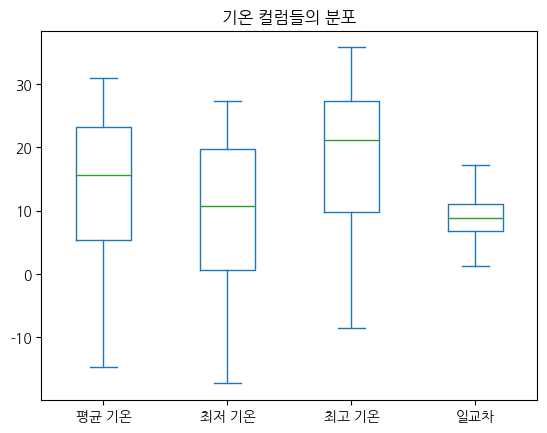

In [208]:
processed_weather_df[['평균 기온', '최저 기온', '최고 기온', '일교차']].plot(kind='box')
plt.title('기온 컬럼들의 분포')
plt.show()

#### 2-2-5. 데이터 확인 및 전처리 (비)

In [161]:
processed_weather_df[
    (processed_weather_df['강수 계속시간'] > 0) &
    (processed_weather_df['일강수량'] > 0)
]['일시'].count()

104

전체 비 온 날이 104일

In [162]:
processed_weather_df[
    (processed_weather_df['강수 계속시간'] > 0) &
    (processed_weather_df['일강수량'] > 0)
][['강수 계속시간', '일강수량']].describe()

,강수 계속시간,일강수량
count,104.000000,104.000000
mean,8.752692,14.702885
std,6.937633,21.172277
min,0.670000,0.100000
25%,2.920000,1.075000
50%,6.750000,3.550000
75%,13.395000,25.025000
max,24.000000,91.600000


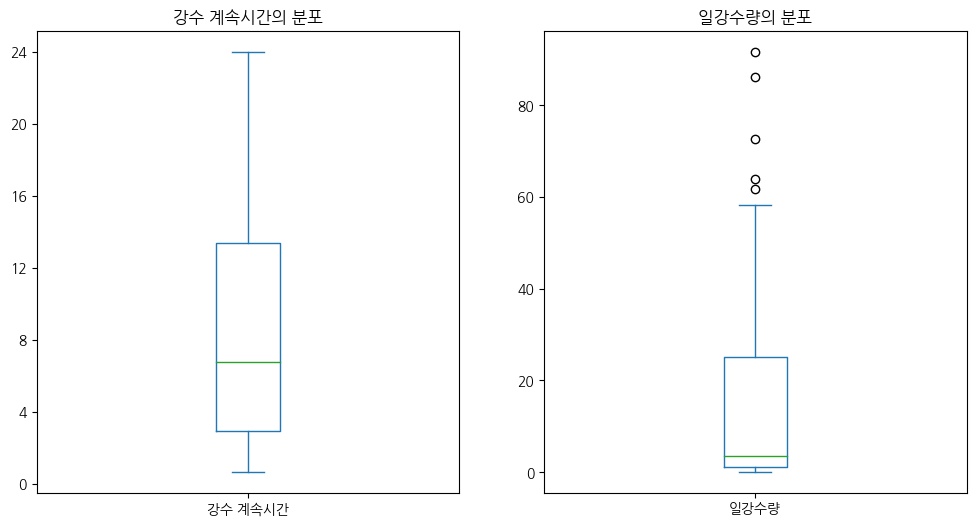

In [167]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

processed_weather_df[
    (processed_weather_df['강수 계속시간'] > 0) &
    (processed_weather_df['일강수량'] > 0)
][['강수 계속시간']].plot(kind='box', ax=axes[0])
axes[0].set_title('강수 계속시간의 분포')
axes[0].set_yticks([i for i in range(0, 25, 4)])

processed_weather_df[
    (processed_weather_df['강수 계속시간'] > 0) &
    (processed_weather_df['일강수량'] > 0)
][['일강수량']].plot(kind='box', ax=axes[1])
axes[1].set_title('일강수량의 분포')

plt.show()

일반적으로 비 오는 날에는 약 3시간 ~ 13시간 정도 비가 오고, 그때의 강수량은 약 1mm ~ 25mm이다. 하루 종일 비가 오는 경우도 이상치로 고려되지는 않는 점을 확인해 볼 수 있다.

#### 2-2-6. 데이터 확인 및 전처리 (바람)

In [171]:
processed_weather_df['평균 풍속'].describe().to_frame()

,평균 풍속
count,365.000000
mean,2.224110
std,0.578336
min,1.100000
25%,1.800000
50%,2.100000
75%,2.500000
max,5.400000


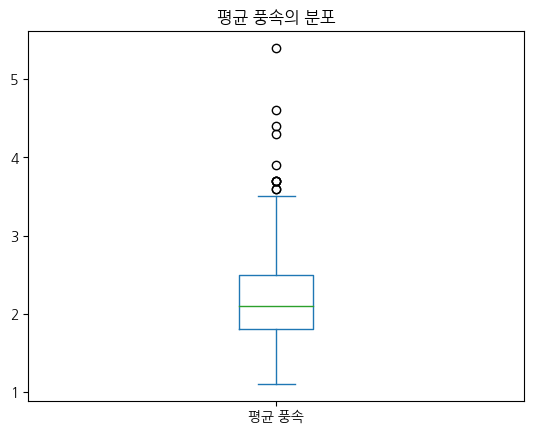

In [170]:
processed_weather_df['평균 풍속'].plot(kind='box')
plt.title('평균 풍속의 분포')
plt.show()

#### 2-2-7. 데이터 확인 및 전처리 (습도)

In [175]:
processed_weather_df['평균 상대습도'].describe().to_frame()

,평균 상대습도
count,365.000000
mean,65.786575
std,14.603963
min,22.900000
25%,55.800000
50%,66.600000
75%,75.400000
max,99.100000


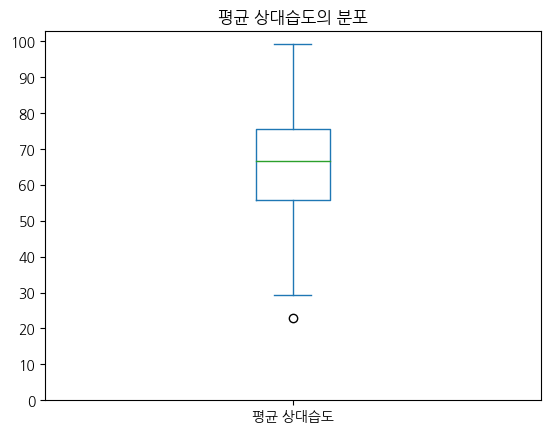

In [178]:
processed_weather_df['평균 상대습도'].plot(kind='box')
plt.title('평균 상대습도의 분포')
plt.yticks([i for i in range(0, 101, 10)])
plt.show()

#### 2-2-8. 데이터 확인 및 전처리 (날씨)

In [180]:
processed_weather_df[['합계 일조 시간', '1시간 최대 일사량', '평균 전운량']].describe()

,합계 일조 시간,1시간 최대 일사량,평균 전운량
count,365.000000,365.000000,365.000000
mean,6.286301,2.250849,4.765479
std,3.902046,0.887868,3.062017
min,0.000000,0.190000,0.000000
25%,2.700000,1.760000,2.100000
50%,7.100000,2.300000,4.800000
75%,9.400000,2.990000,7.100000
max,13.300000,3.700000,10.000000


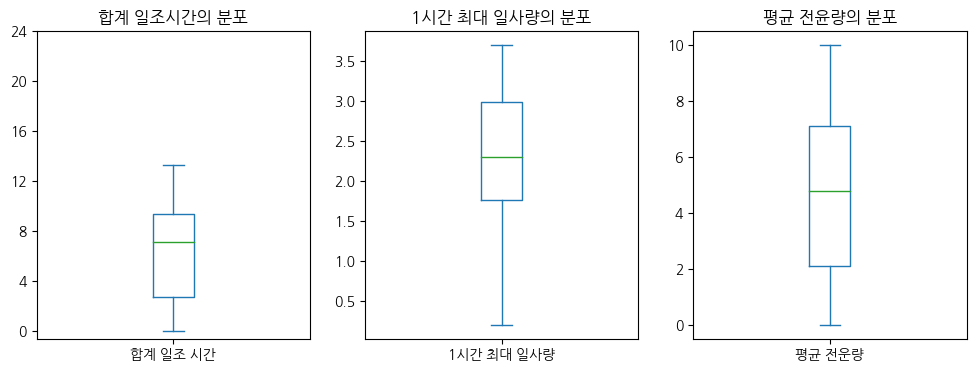

In [183]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

processed_weather_df['합계 일조 시간'].plot(kind='box', ax=axes[0])
axes[0].set_title('합계 일조시간의 분포')
axes[0].set_yticks([i for i in range(0, 25, 4)])

processed_weather_df['1시간 최대 일사량'].plot(kind='box', ax=axes[1])
axes[1].set_title('1시간 최대 일사량의 분포')

processed_weather_df['평균 전운량'].plot(kind='box', ax=axes[2])
axes[2].set_title('평균 전윤량의 분포')

plt.show()

이 세 컬럼은 햇빛, 구름과 관련이 있기 때문에 세 컬럼 사이의 관계가 유의미하게 있을 것 같은 느낌이 든다.

In [185]:
processed_weather_df[['합계 일조 시간', '1시간 최대 일사량', '평균 전운량']].corr()

,합계 일조 시간,1시간 최대 일사량,평균 전운량
합계 일조 시간,1.000000,0.768526,-0.849752
1시간 최대 일사량,0.768526,1.000000,-0.517613
평균 전운량,-0.849752,-0.517613,1.000000


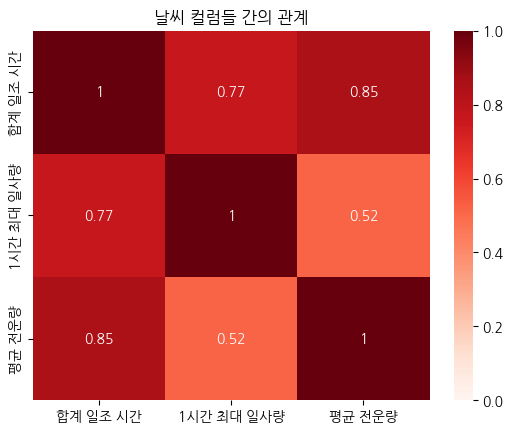

In [202]:
sns.heatmap(
    np.abs(processed_weather_df[['합계 일조 시간', '1시간 최대 일사량', '평균 전운량']].corr()),
    cmap='Reds',
    annot=True,
    vmin=0,
    vmax=1
)
plt.title('날씨 컬럼들 간의 관계')
plt.show()

간략하게 correlation matrix와 heatmapd을 찍어본 결과 역시 그런 경향이 있다. 구름이 없을수록 일조 시간(-0.85)과 일사량(-0.52)이 많고, 일조 시간이 길수록 일사량(0.77)도 많다. 그렇다면 추후 모델링을 할 때 **다중공선성을 고려**하여 '합계 일조 시간' 컬럼만을 사용하는 게 좋겠다.

In [203]:
processed_weather_df = processed_weather_df.drop(['1시간 최대 일사량', '평균 전운량'], axis=1)
processed_weather_df

,일시,평균 기온,최저 기온,최고 기온,평균 풍속,평균 상대습도,합계 일조 시간,강수 계속시간,일강수량,일교차
0,2022-11-01,13.1,9.4,17.8,1.8,73.5,4.7,0.00,0.0,8.4
1,2022-11-02,11.1,5.5,17.9,1.7,57.1,9.6,0.00,0.0,12.4
2,2022-11-03,9.3,5.6,13.4,2.0,58.1,0.6,1.75,0.0,7.8
3,2022-11-04,4.9,1.6,9.8,2.9,41.8,9.6,0.00,0.0,8.2
4,2022-11-05,6.5,0.8,13.6,1.7,51.3,9.7,0.00,0.0,12.8
...,...,...,...,...,...,...,...,...,...,...
360,2023-10-27,15.7,12.6,20.2,1.9,71.1,4.6,0.00,0.0,7.6
361,2023-10-28,14.2,9.4,20.7,1.4,62.9,9.7,0.00,0.0,11.3
362,2023-10-29,14.9,9.8,21.8,1.7,61.6,9.7,0.00,0.0,12.0
363,2023-10-30,15.1,9.7,21.9,1.7,72.0,9.3,0.00,0.0,12.2


In [210]:
with open('processed_weather_df.pkl', 'wb') as file:
    pickle.dump(processed_weather_df, file)

print('저장 완료')

저장 완료


---

## 3. 데이터 분석

아이디어를 브레인스토밍한 결과가 아래와 같다.
- **서울시 입장**: 자전거 이용건수를 분석하여 야외활동이 많은 날과 적은 날을 확인 → 공공자전거 이용건수 예측 → 다양한 정책에 활용(야외활동 좋은 날에는 한강공원에서 문화행사 개최, 야외활동 나쁜 날에는 야외활동 자제하라는 안전안내문자 발송 등)
- **자전거 렌탈 업체 입장**: 자전거 이용 수요가 폭발적으로 증가하는 날을 발굴 → 서울시 내 공공자전거 대여소가 미비된 주요 거점에서 임시 대여소 운영

이 중 **서울시 입장**의 시나리오로 분석 프로젝트를 진행한다. 날씨 요인에 따른 공공자전거 이용건수를 예측하고, 이를 바탕으로 서울시민의 야외활동성을 분석하여 서울시 정책에 활용할 방향성을 고안해 본다.

### 3-1. 데이터 전처리

#### 3-1-1. 데이터 로딩 및 병합

In [2]:
with open ('daily_cycle_df.pkl', 'rb') as file:
    daily_cycle_df = pickle.load(file)

In [3]:
with open ('processed_weather_df.pkl', 'rb') as file:
    processed_weather_df = pickle.load(file)

In [4]:
daily_cycle_df

,대여년월,대여건수,반납건수,이용건수
0,2022-11-01,162842,162234,325076
1,2022-11-02,161055,160438,321493
2,2022-11-03,146605,146241,292846
3,2022-11-04,127647,127153,254800
4,2022-11-05,109234,108505,217739
...,...,...,...,...
359,2023-10-27,192166,190946,383112
360,2023-10-28,160666,160182,320848
361,2023-10-29,147369,147259,294628
362,2023-10-30,186842,186110,372952


In [5]:
processed_weather_df

,일시,평균 기온,최저 기온,최고 기온,평균 풍속,평균 상대습도,합계 일조 시간,1시간 최대 일사량,평균 전운량,강수 계속시간,일강수량,일교차
0,2022-11-01,13.1,9.4,17.8,1.8,73.5,4.7,1.72,3.4,0.00,0.0,8.4
1,2022-11-02,11.1,5.5,17.9,1.7,57.1,9.6,2.42,0.0,0.00,0.0,12.4
2,2022-11-03,9.3,5.6,13.4,2.0,58.1,0.6,1.17,6.1,1.75,0.0,7.8
3,2022-11-04,4.9,1.6,9.8,2.9,41.8,9.6,2.43,0.1,0.00,0.0,8.2
4,2022-11-05,6.5,0.8,13.6,1.7,51.3,9.7,2.37,0.0,0.00,0.0,12.8
...,...,...,...,...,...,...,...,...,...,...,...,...
360,2023-10-27,15.7,12.6,20.2,1.9,71.1,4.6,1.87,3.8,0.00,0.0,7.6
361,2023-10-28,14.2,9.4,20.7,1.4,62.9,9.7,2.36,0.0,0.00,0.0,11.3
362,2023-10-29,14.9,9.8,21.8,1.7,61.6,9.7,2.40,0.0,0.00,0.0,12.0
363,2023-10-30,15.1,9.7,21.9,1.7,72.0,9.3,2.28,1.1,0.00,0.0,12.2


In [6]:
merged_df = pd.merge(
    left=daily_cycle_df,
    right=processed_weather_df,
    left_on='대여년월',
    right_on='일시',
    how='left'
)

merged_df

,대여년월,대여건수,반납건수,이용건수,일시,평균 기온,최저 기온,최고 기온,평균 풍속,평균 상대습도,합계 일조 시간,1시간 최대 일사량,평균 전운량,강수 계속시간,일강수량,일교차
0,2022-11-01,162842,162234,325076,2022-11-01,13.1,9.4,17.8,1.8,73.5,4.7,1.72,3.4,0.00,0.0,8.4
1,2022-11-02,161055,160438,321493,2022-11-02,11.1,5.5,17.9,1.7,57.1,9.6,2.42,0.0,0.00,0.0,12.4
2,2022-11-03,146605,146241,292846,2022-11-03,9.3,5.6,13.4,2.0,58.1,0.6,1.17,6.1,1.75,0.0,7.8
3,2022-11-04,127647,127153,254800,2022-11-04,4.9,1.6,9.8,2.9,41.8,9.6,2.43,0.1,0.00,0.0,8.2
4,2022-11-05,109234,108505,217739,2022-11-05,6.5,0.8,13.6,1.7,51.3,9.7,2.37,0.0,0.00,0.0,12.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,2023-10-27,192166,190946,383112,2023-10-27,15.7,12.6,20.2,1.9,71.1,4.6,1.87,3.8,0.00,0.0,7.6
360,2023-10-28,160666,160182,320848,2023-10-28,14.2,9.4,20.7,1.4,62.9,9.7,2.36,0.0,0.00,0.0,11.3
361,2023-10-29,147369,147259,294628,2023-10-29,14.9,9.8,21.8,1.7,61.6,9.7,2.40,0.0,0.00,0.0,12.0
362,2023-10-30,186842,186110,372952,2023-10-30,15.1,9.7,21.9,1.7,72.0,9.3,2.28,1.1,0.00,0.0,12.2


#### 3-1-2. 상관관계 확인

다중공선성 고려하여, 상관관계 확인 후 사용할 컬럼을 선정한다.

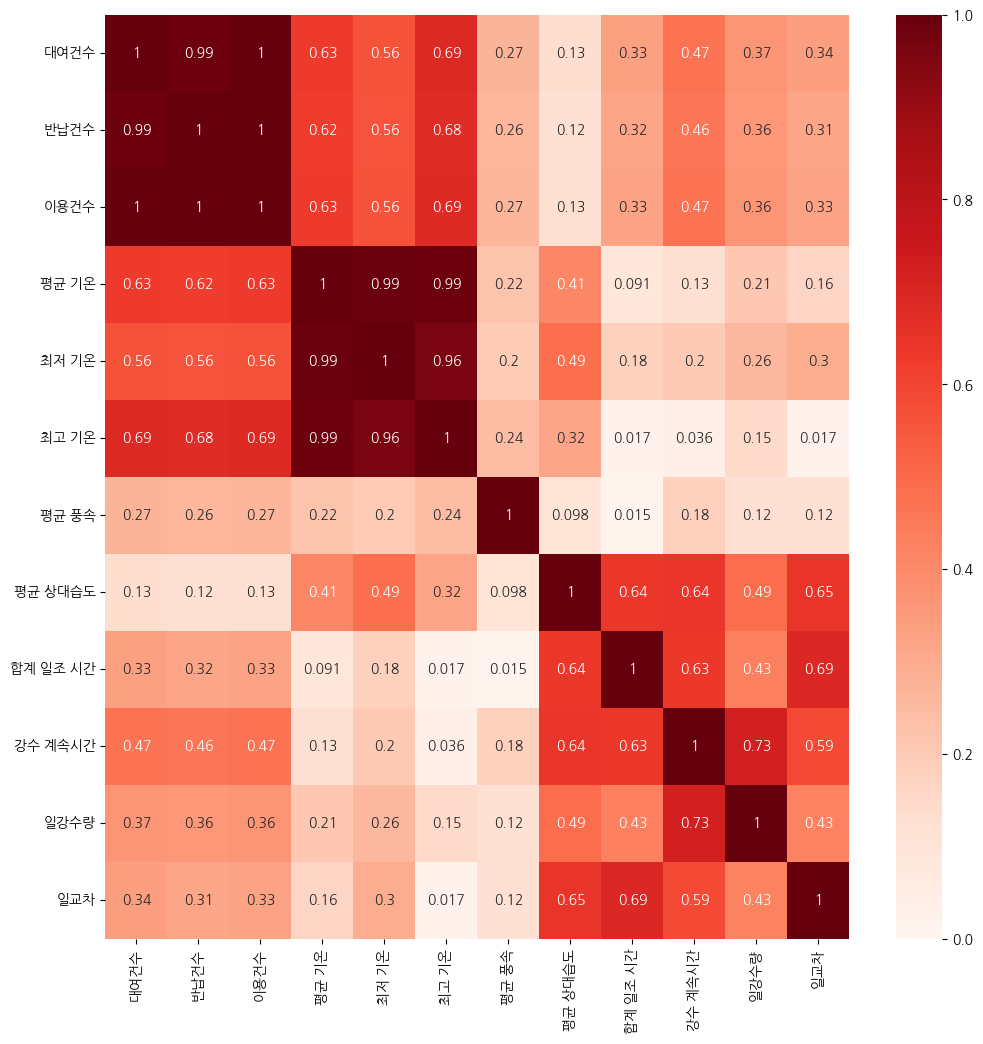

In [21]:
plt.figure(figsize=(12, 12))
sns.heatmap(
    merged_df.drop(['대여년월', '일시', '1시간 최대 일사량', '평균 전운량'], axis=1).corr().abs(),
    cmap='Reds',
    annot=True,
    vmin=0,
    vmax=1
)

plt.show()

- 대여건수와 반납건수는 완전한 선형이라고 봐도 무방하다. 사실상 거의 같이 가는 컬럼 → 본 분석에서 **'이용건수'** 활용
- 최저, 최고, 평균 기온들 간의 상관관계도 뚜렷하므로 굳이 세 컬럼을 모두 활용할 필요가 없다. → 본 분석에서 **'평균 기온'** 활용
- 평균 풍속은 다른 컬럼들의 영향을 크게 안 받는 컬럼이라고 봐도 되겠다. → 본 분석에서 **'평균 풍속'** 활용
- 평균 상대습도, 합계 일조시간, 강수 계속시간, 일강수량, 일교차의 5개 컬럼은 계절감을 반영하기 때문에 서로 물고 물리는 관계라고 봐도 무방하겠다. → 본 분석에서 **평균 상대습도**, **일강수량** 활용

In [7]:
new_merged_df = merged_df[['대여년월', '이용건수', '평균 기온', '평균 풍속', '평균 상대습도', '일강수량']]
new_merged_df

,대여년월,이용건수,평균 기온,평균 풍속,평균 상대습도,일강수량
0,2022-11-01,325076,13.1,1.8,73.5,0.0
1,2022-11-02,321493,11.1,1.7,57.1,0.0
2,2022-11-03,292846,9.3,2.0,58.1,0.0
3,2022-11-04,254800,4.9,2.9,41.8,0.0
4,2022-11-05,217739,6.5,1.7,51.3,0.0
...,...,...,...,...,...,...
359,2023-10-27,383112,15.7,1.9,71.1,0.0
360,2023-10-28,320848,14.2,1.4,62.9,0.0
361,2023-10-29,294628,14.9,1.7,61.6,0.0
362,2023-10-30,372952,15.1,1.7,72.0,0.0


#### 3-1-3. 데이터 표준화

In [8]:
scaler = StandardScaler()
X = pd.DataFrame()
X[['평균 기온', '평균 풍속', '평균 상대습도', '일강수량']] = scaler.fit_transform(
    new_merged_df[['평균 기온', '평균 풍속', '평균 상대습도', '일강수량']]
)
y = new_merged_df['이용건수']
X.shape, y.shape

((364, 4), (364,))

#### 3-1-4. 데이터 스플릿

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((291, 4), (73, 4), (291,), (73,))

### 3-2. 회귀모델 생성

#### 3-2-1. 모델 선정

여러 개의 회귀 모델을 테스트하여 가장 좋은 성능을 보이는 모델을 채택한다.

In [48]:
models = {
    "Decision Tree Regression": DecisionTreeRegressor(),
    "Random Forest Regression": RandomForestRegressor(),
    "XGBoost": XGBRegressor(tree_method = "hist", device = "cuda"),
    "LightGBM": LGBMRegressor(verbosity=-1, device_type='gpu') #verbosity: 그냥 돌리면 자꾸 딴 말 나와서 -1로 설정
}

In [51]:
results = {}
# 검증 수행 및 RMSE 평가
results = {}
for model_name, model in models.items():
    print(f"[{model_name}] ... ", end='')
    start = datetime.now()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    end = datetime.now()
    results['model_name'] = mse
    print(f"{mse} / {end - start}")

[Decision Tree Regression] ... 3859166595.6438355 / 0:00:00.003986
[Random Forest Regression] ... 2027541948.9464228 / 0:00:00.169720
[XGBoost] ... 1875790152.6372044 / 0:00:00.454451
[LightGBM] ... 2151814665.4131484 / 0:00:00.228711


In [52]:
min(results.values())

2151814665.4131484

하이퍼 파라미터를 하나도 건드리지 않은 상황에서는 **LightGBM**의 성능이 가장 좋다.

#### 3-2-2. 하이퍼 파라미터 튜닝

LightGBM 모델을 생성한 뒤, GridSearch를 통해 하이퍼 파라미터 튜닝을 진행한다.

In [10]:
# LightGBM 모델 정의
model = LGBMRegressor(verbosity=-1, device_type='gpu')

In [54]:
# 그리드 서치를 위한 하이퍼 파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

# 그리드 서치 객체 생성
grid_search_lgbm = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# 그리드 서치 수행
grid_search_lgbm.fit(X, y)

# 최적 하이퍼파라미터 및 결과 출력
best_params_lgbm = grid_search_lgbm.best_params_
best_score_lgbm = np.sqrt(-grid_search_lgbm.best_score_)
print("LightGBM - Best Parameters:", best_params_lgbm)
print("LightGBM - RMSE:", best_score_lgbm)

LightGBM - Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
LightGBM - RMSE: 50613.09935518168


In [55]:
# 그리드 서치를 위한 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 500, 700, 1000],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.001, 0.005, 0.01, 0.015]
}

# 그리드 서치 객체 생성
grid_search_lgbm = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# 그리드 서치 수행
grid_search_lgbm.fit(X, y)

# 최적 하이퍼파라미터 및 결과 출력
best_params_lgbm = grid_search_lgbm.best_params_
best_score_lgbm = np.sqrt(-grid_search_lgbm.best_score_)
print("LightGBM - Best Parameters:", best_params_lgbm)
print("LightGBM - RMSE:", best_score_lgbm)

LightGBM - Best Parameters: {'learning_rate': 0.015, 'max_depth': 2, 'n_estimators': 500}
LightGBM - RMSE: 49619.085191388665


In [57]:
# 그리드 서치를 위한 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 500, 700, 1000, 2000],
    'max_depth': [1, 3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.02, 0.03, 0.1]
}

# 그리드 서치 객체 생성
grid_search_lgbm = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# 그리드 서치 수행
grid_search_lgbm.fit(X, y)

# 최적 하이퍼파라미터 및 결과 출력
best_params_lgbm = grid_search_lgbm.best_params_
best_score_lgbm = np.sqrt(-grid_search_lgbm.best_score_)
print("LightGBM - Best Parameters:", best_params_lgbm)
print("LightGBM - RMSE:", best_score_lgbm)

LightGBM - Best Parameters: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 2000}
LightGBM - RMSE: 49746.95189635809


In [58]:
# 그리드 서치를 위한 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [2000, 3000, 4000],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.01, 0.015, 0.02, 0.03]
}

# 그리드 서치 객체 생성
grid_search_lgbm = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# 그리드 서치 수행
grid_search_lgbm.fit(X, y)

# 최적 하이퍼파라미터 및 결과 출력
best_params_lgbm = grid_search_lgbm.best_params_
best_score_lgbm = np.sqrt(-grid_search_lgbm.best_score_)
print("LightGBM - Best Parameters:", best_params_lgbm)
print("LightGBM - RMSE:", best_score_lgbm)

LightGBM - Best Parameters: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 2000}
LightGBM - RMSE: 49746.95189762842


In [59]:
# 그리드 서치를 위한 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [1500, 2000, 2500],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.005, 0.01, 0.015]
}

# 그리드 서치 객체 생성
grid_search_lgbm = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# 그리드 서치 수행
grid_search_lgbm.fit(X, y)

# 최적 하이퍼파라미터 및 결과 출력
best_params_lgbm = grid_search_lgbm.best_params_
best_score_lgbm = np.sqrt(-grid_search_lgbm.best_score_)
print("LightGBM - Best Parameters:", best_params_lgbm)
print("LightGBM - RMSE:", best_score_lgbm)

LightGBM - Best Parameters: {'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 1500}
LightGBM - RMSE: 49685.319278514115


In [66]:
best_model = grid_search_lgbm.best_estimator_
best_model

LGBMRegressor(device_type='gpu', learning_rate=0.005, max_depth=2,
              n_estimators=1500, verbosity=-1)

```learning_rate=0.005, max_depth=2, n_estimators=1500```일 때의 성능이 가장 높게 나왔으므로 이를 최종 모델로 채택한다.

### 3-3. 공공자전거 이용건수 예측

앞서 가공한 1년치 데이터를 이용하여 이용건수 예측치를 생성한다.

In [16]:
pred_result = best_model.predict(X)
pred_result.shape

(364,)

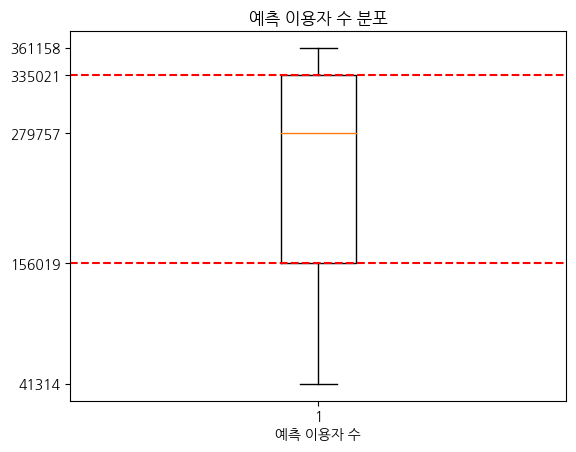

In [17]:
plt.boxplot(pred_result)
plt.xlabel('예측 이용자 수')
plt.yticks([
    np.round(np.min(pred_result)),
    np.round(np.quantile(pred_result, 0.25)),
    np.round(np.median(pred_result)),
    np.round(np.quantile(pred_result, 0.75)),
    np.round(np.max(pred_result))
])
plt.axhline(np.round(np.quantile(pred_result, 0.25)), color='red', linestyle='--')
plt.axhline(np.round(np.quantile(pred_result, 0.75)), color='red', linestyle='--')
plt.title('예측 이용자 수 분포')

plt.show()

- 예측 이용자 수가 제3사분위수(335,021)보다 높은 날은 상위 25%에 해당하는 날이므로 **야외활동지수가 높은 날**로 간주한다.
    - 공휴일, 주말 등이 일기예보를 통해 도출한 '야외활동지수가 높은 날'인 경우, 공공자전거와 문화 시설을 연계한 행사를 개최하거나, 할인 쿠폰을 발급하는 등의 판촉을 진행한다.
    - 일기예보를 통해 도출한 '야외활동지수가 높은 날'에 관내에서 대형 행사가 주최되는 경우, 많은 인원이 한꺼번에 몰릴 가능성이 있으므로 안전사고 관리 부서의 당직 인원을 더 많이 배치한다.
- 예측 이용자 수가 제1사분위수(156,019)보다 작은 날은 하위 25%에 해당하는 날이므로 **야외활동지수가 낮은 날**로 간주한다.
    - '야외활동지수가 낮은 날'이면서 특별히 혹한, 혹서, 폭우 등의 기상 상황이 동반되는 경우, 공공자전거의 이용을 일시적으로 제한하는 시스템을 구축한다.
    - 일기예보를 통해 도출한 '야외활동지수가 낮은 날'에 관내에서 대형 행사가 주최되는 경우, 사고 조치를 위한 현장 인원을 더 많이 배치한다.
    - '야외활동지수가 낮은 날' 동안은 차량 이용량이 많아질 것으로 예측된다. 따라서 도로 전광판이나 안전안내문자 등을 통해 대중교통 이용을 장려하고 우회도로를 안내한다. 상황의 경중에 따라 서울시 대중교통 요금을 일시적으로 할인하는 조치를 시행할 수 있다.

---

## 4. 후기

서울시 공공자전거 이용현황 데이터와 기상청 일 관측자료 데이터를 결합하여, 공공자전거 이용건수를 예측하는 머신러닝 모델을 생성하였다. 이를 바탕으로 야외활동지수가 높은 날과 낮은 날을 구분하고, 각 상황에 따른 여러 정책을 제안하였다.

우리 주변에서 흔히 접할 수 있는 친숙한 데이터들을 이용하여 분석을 진행해 보았다. 혹자는 '따릉이', '날씨' 두 키워드가 너무 식상하다고 할 수도 있겠으나, 그 만큼 분석하기 용이한 데이터라는 방증이기도 할 것이다.

두 API를 직접 핸들링하는 과정을 거쳐야 했기에 분석 초반에 할 일들이 꽤 있었다. 특히 공공자전거 API의 경우 날짜별 처리와 인덱스별 처리를 모두 거쳐야 했기에 약간은 까다로운 과정이었다. 기상청 API의 경우 제공하는 컬럼이 너무 많아서 본 프로젝트에 어울리는 컬럼을 선별해야 하는 과정이 번거로웠다. 기상에 대한 지식이 미비했기 때문에 무엇을 뜻하는지 전혀 모르겠는 컬럼들도 있었다. 데이터 분석가가 현업에서 도메인 지식 부족에 직면하는 경우 낭패를 볼 수 있음을 엿봤다.

본 분석에서 가장 아쉬웠던 점은 역시 기온에 대한 처리가 아닐까 싶다. 사실 기온과 이용건수는 선형관계를 띨 수가 없다. 겨울철에는 기온이 높아질수록 이용건수가 높아질 테고, 반대로 여름철에는 기온이 낮아질수록 이용건수가 높아질 것이기 때문이다. 이러한 처리를 올바르게 해주는 방법에 대해 고민해 볼 필요가 있겠다.

또한 본 분석에서는 단순위 사분위수를 이용하여 야외활동지수 높은 날과 낮은 날을 분류했는데 그 기준점을 통계적으로 명확하게 잡는 방법에 대해서도 생각해 볼 필요가 있겠다고 느꼈다. 예를 들어 본 표본이 정규분포를 따른다고 한다면 Z-score를 매기고 이를 바탕으로 validation을 진행할 수도 있었을 것이다.